# Quantum Key Distribution

Quantum cryptography or quantum key distribution (QKD) is a procedure that enables provably secure distribution of private information. 

## The BB84 Protocol

In this demo, we introduce the [BB84 Protocol](https://arxiv.org/abs/quant-ph/0003004), which is one of the earliest QKD protocols.

***
### Contributors
Faris Sbahi, Kya Sorli, Samantha Washko

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$

## [The Algorithm](http://www-reynal.ensea.fr/docs/iq/QC10th.pdf)

1. Alice choose $(4 + \delta)n$ random data bits
2. Alice chooses a random $(4 + \delta)n$-bit string $b$. She encodes each data bit as $\{ \ket{0}, \ket{1}\}$ if the corresponding bit of $b$ is 0 or $\{ \ket{+}, \ket{-}\}$ if $b$ is 1.
3. Alice sends the resulting state to Bob
4. Bob receives the $(4 + \delta)n$ qubits, announces this fact, and measures each qubit in the $X$ or $Z$ basis at random. 
5. Alice announces $b$
6. Alice and Bob discard any bits where Bob measured a different basis than Alice prepared. With high probability, there are at least $2n$ bits left (if not, abort the protocol). They keep $2n$ bits.
7. Alice selects a subset of $n$ bits that will serve as a check on Eve's interference, and tells bob which bits she selected.
8. Alice and Bob announce and compare the values of the $n$ check bits. If more than an acceptable number disagree, they abort the protocol.
9. Alice and Bob perform information reconciliation and privacy amplification on the remaining $n$ bits to obtains $m$ shared key bits. 

Here we let $\delta = 0$. See the writeup for a bound on the error in the check bits and remaining $n$ bits using this $\delta$. 

## The Circuit <a id="circuit"></a>

We can implement this protocol with QISKit by first preparing the environment.

In [1]:
#initialization
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random 
import numpy as np

# importing the QISKit
from qiskit import QuantumProgram

qx_config = {
        "APItoken":"e37f539f37fd1ac9d17f25b0803dcc567fe1230ef7ae5580e58f9d5f28c6c4c685eeec806840b6ae62f99a947d2456d488dedc86e960d09d392ff0e071a4db71",
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

#set api
from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

#prepare backends
from qiskit.backends import discover_local_backends, discover_remote_backends, get_backend_instance
remote_backends = discover_remote_backends(api) #we have to call this to connect to remote backends
local_backends = discover_local_backends()

We now define the actions that Alice and Bob can take as methods of their respective classes. 

In [204]:
class Alice:
    def prepareState(self, n, delta):
        
        nQubits = int((4 + delta)*n) # number of physical qubits
        
        a = np.random.randint(2, size=(nQubits,))      # random data bits
        b = np.random.randint(2, size=(nQubits,))
        
        print("Alice has generated random secret data bits, a: ", a)
        print("She will arbitrarily encode these bits using random basis, b: ", b)
        return (a, b)
    
class Bob:
    def generateRandomBasis(self, n):
        nQubits = int((4 + delta)*n) # number of physical qubits
        b = np.random.randint(2, size=(nQubits,))
        
        print("Bob has chosen random basis, b': ", b)
        return b
        
class Eve:
    def generateRandomBasis(self, n):
        nQubits = int((4 + delta)*n) # number of physical qubits
        b = np.random.randint(2, size=(nQubits,))
        
        print("Eve has chosen random basis: ", b)
        return b

We then use QISKit and the above classes to simulate key exchange between Alice and Bob.

We construct two circuits: BB84 which has no eavesdroppers and BB84-Eve where Eve eavesdrops by performing measurements before the qubits reach Bob.

Note that we choose $n \leq 8$ (key length) and $\delta = 0$ (justified given that we aren't communicating over a noisy channel) for our experiment. We choose a small key length due to our computational constraints. In practice, one would use a much larger key size.

In [208]:
def BB84Program(key_length):
    qp = QuantumProgram()
    
    # key length
    n = key_length
    # error slack
    delta = 0
    # number of physical qubits
    nQubits = int((4 + delta)*n)
    
    # Creating registers
    # qubits for querying the oracle and finding the hidden integer
    qr_1 = qp.create_quantum_register("qr_1", nQubits)
    # for recording the measurement on qr
    cr_1 = qp.create_classical_register("cr_1", nQubits)
    
    # qubits for querying the oracle and finding the hidden integer
    qr_2 = qp.create_quantum_register("qr_2", nQubits)
    # for recording the measurement on qr
    cr_2 = qp.create_classical_register("cr_2", nQubits)
    
    circuitName = "BB84"
    circuitName_eve = "BB84-Eve"
    bbCircuit = qp.create_circuit(circuitName, [qr_1], [cr_1])
    bb_eve_Circuit = qp.create_circuit(circuitName_eve, [qr_2], [cr_2])
    
    # Initialize Alice and Bob ... and Eve! 
    alice = Alice()
    bob = Bob()
    eve = Eve()
    
    # Have Alice generate secrets a, b with chosen n and delta
    (a, b) = alice.prepareState(n, delta)
    
    # Apply Hadamard gates before querying the oracle
    for i in range(nQubits):
        if a[i] == 1:
            # X gates will send |0> -> |1> 
            bbCircuit.x(qr_1[i])
            bb_eve_Circuit.x(qr_2[i])
    
    for i in range(nQubits):
        if b[i] == 1:
            # encode in X basis
            bbCircuit.h(qr_1[i])
            bb_eve_Circuit.h(qr_2[i])
    
    # Bob generates his random basis string, b'
    b_prime = bob.generateRandomBasis(n)
    
    # Eve also takes a stab at guessing the basis
    b_eve = eve.generateRandomBasis(n)
    
    # Eve makes some measurements !
    for i in range(nQubits):
        if b_eve[i] == 1:
            # measure in X basis (otherwise Eve measures in Z)
            bb_eve_Circuit.h(qr_2[i])
    
    # Bob measures the qubits based off of b'
    
    for i in range(nQubits):
        if b_prime[i] == 1:
            # measure in X basis (as opposed to Z)
            bbCircuit.h(qr_1[i])
            bb_eve_Circuit.h(qr_2[i])
        
    for i in range(nQubits):
        bbCircuit.measure(qr_1[i], cr_1[i])
        bb_eve_Circuit.measure(qr_2[i], cr_2[i])
        
    return (qp, a, b, b_prime)

Once Bob performs his measurements, using this circuit, we can perform steps 5-9. We define a method to do these steps.

In [209]:
def determineKey(a, bob_meas, b, b_prime):
    # Now, it is safe for Alice to announce b to Bob. They can then determine in which places their b and b' agree.
    # Let's call the indices where b_i = b'_i, array x
    x = [b_i == b_prime_i for (b_i, b_prime_i) in zip(b, b_prime)]
    
    # The size of x should be 1/2 nQubits, in expectation
    if np.sum(x) < n / 2:
        print("Aborting protocol. Less than 2n bits match between b and b'")
        return False
    else:
        # We can then use this to discard the key bits accordingly (on each side)
    
        # Alice's original secret key, a, subsetted where b and b' agree
        alice_bits = a[x]
        # Bob's measurement in his random basis b', subsetted where b and b' agree
        bob_bits = bob_meas[x]
    
        # Now, we can use half of these bits as "check bits" to see if there was any interference (announcing publicly)
        # Let's just take the first n bits as check bits, WLOG
        
        check_alice = alice_bits[:n]
        key_alice = alice_bits[-n:]
        check_bob = bob_bits[:n]
        key_bob = bob_bits[-n:]
        
        print("Alice has check bits: ", check_alice)
        print("Bob has check bits: ", check_bob)
        
        # Now, they publicly determine the error in their check bits
        mismatch = [k_a != k_b for (k_a, k_b) in zip(key_alice, key_bob)]
        error = (np.sum(mismatch)) / n
        
        # Let's choose epsilon = 0.05 as our error threshold
        epsilon = 0.05
        if error > epsilon:
            print("Interference detected... Aborting!")
            return False
        else:
            print("Successfully exchanged private key: ", key_alice)
            return True

## Experiment with Simulators

We can run the above circuits in the simulator. This will gives us the results of Bob's measurements using his random basis, in both cases (with or without eavesdropping). If there is no noise or interference by Eve, then Bob's measurements should match up precisely with Alice's key $a$, at the qubits where Alice and Bob both chose the same basis. Hence, we can take this subset of Bob's measurement to use as check bits and key bits. 

We also show the probabilities of various outcomes Bob could see, which are computed by simulating the above circuit using the same $a$, $b$, and $b'$, $2^{10}$ times noting the number of occurences of each outcome. 

In [210]:
def testCircuits(shots, key_length):
    # use local qasm simulator
    backend = 'ibmqx_hpc_qasm_simulator'
    qp, a, b, b_prime = BB84Program(key_length)
    
    print("Simulating...")
    
    results = qp.execute(["BB84"], backend=backend, timeout=600, shots=shots)
    answer = results.get_counts("BB84")
    
    results_eve = qp.execute(["BB84-Eve"], backend=backend, timeout=600, shots=shots)
    answer_eve = results_eve.get_counts("BB84-Eve")
    
    return (answer, answer_eve, a, b, b_prime)

(answer, answer_eve, a, b, b_prime) = testCircuits(2**10, 4)
print("Discrete distribution of potential measurements by Bob: ", answer)
print("Discrete distribution of potential measurements by Bob with eavesdropping: ", answer_eve)

Alice has generated random secret data bits, a:  [1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1]
Bob has chosen random basis, b':  [1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0]
Eve has chosen random basis:  [0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0]
Simulating...
Discrete distribution of potential measurements by Bob:  {'0000011010101101': 19, '0000111010110101': 16, '0000111010100101': 19, '1000111110100101': 10, '0000011110101101': 16, '0001111110111101': 16, '0001111010100101': 17, '0001111010110101': 16, '0001011010101101': 22, '1001111010101101': 14, '1000011110110101': 20, '0000011010110101': 20, '0000111110111101': 20, '1000111110110101': 14, '1000111110101101': 13, '0001011110101101': 10, '0001011110110101': 21, '0000111110100101': 23, '0000111110110101': 8, '1001011110101101': 14, '1000111110111101': 12, '1000011010101101': 16, '0001111110110101': 18, '0001111110100101': 16, '1001011110100101': 15, '1001111110111101

Of course, Bob will not see a probability distribution, but rather one of these particular outcomes. Hence, we'll take one of these outcomes at random.

In [211]:
def getMeasurement(answer, answer_eve):
    bob_meas = list(random.choice(list(answer.keys())))
    bob_meas = list(map(int, bob_meas))
    bob_meas = np.array(bob_meas)
    bob_meas = bob_meas[::-1]
    print("Bob's measurement result: ", bob_meas)
    
    bob_meas_eve = list(random.choice(list(answer_eve.keys())))
    bob_meas_eve = list(map(int, bob_meas_eve))
    bob_meas_eve = np.array(bob_meas_eve)
    bob_meas_eve = bob_meas_eve[::-1]
    print("Bob's measurement result with eavesdropping: ", bob_meas_eve)
    
    return (bob_meas, bob_meas_eve)
    
bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)

Bob's measurement result:  [1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0]
Bob's measurement result with eavesdropping:  [1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0]


Now, we can use the above measurement to determine whether the key exchange was successful or not. In other words, Alice and Bob determine if their check bits agree in enough places so that they can conclude that their was no interference by Eve. 

First, they communicate over a classical channel to determine where their choices in random bases agreed.

In [212]:
print("Key Exchange without eavesdropping: ")
res = determineKey(a, bob_meas, b, b_prime)
print("Key Exchange with eavesdropping: ")
res = determineKey(a, bob_meas_eve, b, b_prime)

Key Exchange without eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Successfully exchanged private key:  [0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Successfully exchanged private key:  [0 0]


Hence, we can perform the above steps over many iterations to observe expirementally how likely Alice and Bob are to succeed in key exchange in addition to how likely Eve is to eavesdrop undetected.

In [ ]:
def plot_eve_undetected(probs):
    
    objects = ('2', '4', '8')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, probs, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    
    plt.xlabel("Key Length")
    plt.ylabel('Probability')
    plt.title('Probability of Undetected Eavesdropping')
    
    plt.show()

In [228]:
probs = []

for n in [2, 4, 8]:
    succ = 0
    succ_eve = 0
    for i in range(2**7):
        print("Simulation round:", i)
        # Simulate one measurement with key length n = 4
        (answer, answer_eve, a, b, b_prime) = testCircuits(1, n)
        bob_meas, bob_meas_eve = getMeasurement(answer, answer_eve)
        print("Key Exchange without eavesdropping: ")
        res = determineKey(a, bob_meas, b, b_prime)
        # successful
        if res: 
            succ += 1
        print("Key Exchange with eavesdropping: ")
        res = determineKey(a, bob_meas_eve, b, b_prime)
        # successful
        if res: 
            succ_eve += 1
        
    print("n=", n)
    print("Successful key exchanges without Eve present: ", succ)
    print("Successful key exchanges with Eve present: ", succ_eve)
    p = (succ_eve) / (2**7)
    probs.append(p)
    
plot_eve()

Simulation round: 0
Alice has generated random secret data bits, a:  [0 0 0 0 0 1 0 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 0 0 0 0 0]
Bob has chosen random basis, b':  [1 0 0 0 0 0 0 0]
Eve has chosen random basis:  [1 1 1 0 1 1 1 1]
Simulating...
Bob's measurement result:  [0 1 0 0 0 1 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 0 1 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Interference detected... Aborting!
Simulation round: 1
Alice has generated random secret data bits, a:  [0 1 0 1 1 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 1 1 1 0 1]
Bob has chosen random basis, b':  [1 1 1 1 1 1 0 1]
Eve has chosen random basis:  [0 1 0 0 1 0 0 1]
Simulating...
Bob's measurement result:  [1 1 1 1 1 0 0 1]
Bob's measurement res

Bob's measurement result:  [0 1 0 0 1 1 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 0 0 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Interference detected... Aborting!
Simulation round: 14
Alice has generated random secret data bits, a:  [1 0 1 1 1 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 1 0 0 0 1]
Bob has chosen random basis, b':  [0 1 0 1 1 1 0 0]
Eve has chosen random basis:  [0 1 1 1 0 0 1 0]
Simulating...
Bob's measurement result:  [1 0 0 1 1 1 1 0]
Bob's measurement result with eavesdropping:  [1 0 1 1 1 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully exchanged private key:  [1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully

Bob's measurement result:  [0 1 1 0 1 1 0 1]
Bob's measurement result with eavesdropping:  [0 0 1 1 1 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [1 0]
Simulation round: 27
Alice has generated random secret data bits, a:  [0 1 0 1 1 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 1 0 1 0 1]
Bob has chosen random basis, b':  [1 0 1 1 1 1 1 1]
Eve has chosen random basis:  [1 1 1 0 0 0 0 0]
Simulating...
Bob's measurement result:  [0 0 0 1 1 1 0 1]
Bob's measurement result with eavesdropping:  [0 1 1 1 1 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 1]
Succ

Bob's measurement result:  [1 1 1 0 1 1 0 0]
Bob's measurement result with eavesdropping:  [1 0 1 1 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully exchanged private key:  [1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully exchanged private key:  [1 0]
Simulation round: 40
Alice has generated random secret data bits, a:  [1 0 1 0 1 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 0 1 1 0 1]
Bob has chosen random basis, b':  [0 0 1 1 1 0 1 1]
Eve has chosen random basis:  [0 0 1 0 1 1 1 0]
Simulating...
Bob's measurement result:  [0 0 1 0 1 0 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 0 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully exchanged private key:  [1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [0 0]
Inte

Bob's measurement result:  [0 1 1 0 0 0 1 0]
Bob's measurement result with eavesdropping:  [0 0 0 1 0 0 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [0 0]
Simulation round: 53
Alice has generated random secret data bits, a:  [0 0 1 1 1 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 0 0 1 1 1]
Bob has chosen random basis, b':  [1 1 1 1 1 0 0 0]
Eve has chosen random basis:  [1 0 1 1 0 0 0 0]
Simulating...
Bob's measurement result:  [1 0 1 0 0 1 1 1]
Bob's measurement result with eavesdropping:  [0 0 1 1 0 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1]
Bob has check bits:  [1]
Successfully exchanged private key:  [1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1]
Bob has check bits:  [1]
Successfully e

Bob's measurement result:  [1 1 0 0 0 1 1 0]
Bob's measurement result with eavesdropping:  [1 0 0 0 1 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully exchanged private key:  [0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 0]
Interference detected... Aborting!
Simulation round: 66
Alice has generated random secret data bits, a:  [1 0 1 0 0 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 1 0 1 0 0 0 0]
Bob has chosen random basis, b':  [1 1 1 0 1 1 0 1]
Eve has chosen random basis:  [1 1 0 1 0 1 0 1]
Simulating...
Bob's measurement result:  [1 0 1 0 1 0 1 0]
Bob's measurement result with eavesdropping:  [0 0 0 0 1 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Successfully exchanged private key:  [0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [0 0]
Successfully

Bob's measurement result:  [1 0 1 0 1 0 0 1]
Bob's measurement result with eavesdropping:  [1 0 0 0 0 0 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1]
Bob has check bits:  [1]
Successfully exchanged private key:  [1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1]
Bob has check bits:  [0]
Interference detected... Aborting!
Simulation round: 79
Alice has generated random secret data bits, a:  [1 0 0 1 0 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 1 0 1 1 0]
Bob has chosen random basis, b':  [1 1 1 0 0 0 0 0]
Eve has chosen random basis:  [0 0 1 0 1 1 1 1]
Simulating...
Bob's measurement result:  [1 0 0 0 0 1 1 0]
Bob's measurement result with eavesdropping:  [1 1 1 0 0 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Successfully exchanged private key:  [0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 1]
Interference detected.

Bob's measurement result:  [0 0 0 0 0 0 1 1]
Bob's measurement result with eavesdropping:  [0 1 0 0 1 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Interference detected... Aborting!
Simulation round: 92
Alice has generated random secret data bits, a:  [1 0 0 1 1 1 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 0 0 0 1 1]
Bob has chosen random basis, b':  [0 1 0 1 0 0 0 0]
Eve has chosen random basis:  [0 0 1 1 0 0 1 1]
Simulating...
Bob's measurement result:  [1 1 0 0 1 1 1 1]
Bob's measurement result with eavesdropping:  [1 1 0 1 1 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully exchanged private key:  [1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1]
Bob has check bits:  [1 1]
Successfully

Bob's measurement result:  [0 0 0 0 1 1 0 1]
Bob's measurement result with eavesdropping:  [0 1 1 1 1 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [1 0]
Simulation round: 105
Alice has generated random secret data bits, a:  [0 1 1 0 1 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 1 1 1 0 1 0]
Bob has chosen random basis, b':  [1 1 1 1 0 0 1 1]
Eve has chosen random basis:  [1 0 1 1 1 0 0 0]
Simulating...
Bob's measurement result:  [0 0 1 0 1 0 1 1]
Bob's measurement result with eavesdropping:  [0 1 1 0 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Successfully exchanged private key:  [0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0]
Bob has check bits:  [1 0]
Suc

Bob's measurement result:  [0 0 0 0 1 0 0 1]
Bob's measurement result with eavesdropping:  [1 1 1 0 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1]
Bob has check bits:  [0 1]
Successfully exchanged private key:  [0 1]
Simulation round: 118
Alice has generated random secret data bits, a:  [0 1 0 0 1 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 1 1 1 1 0]
Bob has chosen random basis, b':  [0 1 0 0 0 1 0 0]
Eve has chosen random basis:  [0 1 0 1 0 0 1 1]
Simulating...
Bob's measurement result:  [0 0 0 0 1 0 1 1]
Bob's measurement result with eavesdropping:  [0 1 0 0 0 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Successfully exchanged private key:  [0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0]
Bob has check bits:  [0 0]
Suc

Bob's measurement result:  [0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1]
Bob's measurement result with eavesdropping:  [0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 1 0 1]
Successfully exchanged private key:  [1 1 1 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 0 0 1]
Interference detected... Aborting!
Simulation round: 3
Alice has generated random secret data bits, a:  [0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1]
Bob has chosen random basis, b':  [0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0]
Eve has chosen random basis:  [0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1]
Simulating...
Bob's measurement result:  [0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0]
Bob's measurement result with eavesdropping:  [0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 1 1]
Bob has check bits:  

Bob's measurement result:  [0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0]
Bob's measurement result with eavesdropping:  [0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits:  [1 1 1 0]
Successfully exchanged private key:  [0 0 0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits:  [1 1 1 1]
Interference detected... Aborting!
Simulation round: 14
Alice has generated random secret data bits, a:  [0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0]
Bob has chosen random basis, b':  [1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0]
Eve has chosen random basis:  [1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0]
Simulating...
Bob's measurement result:  [0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1]
Bob's measurement result with eavesdropping:  [0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 0 1]
Bob has check bits: 

Bob's measurement result:  [0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0]
Bob's measurement result with eavesdropping:  [0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 1 0 1]
Successfully exchanged private key:  [0 1 0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 0 0 0]
Interference detected... Aborting!
Simulation round: 25
Alice has generated random secret data bits, a:  [0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1]
Bob has chosen random basis, b':  [0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0]
Eve has chosen random basis:  [0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1]
Simulating...
Bob's measurement result:  [0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0]
Bob's measurement result with eavesdropping:  [1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 0]
Bob has check bits: 

Bob's measurement result:  [0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1]
Bob's measurement result with eavesdropping:  [0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 1 0]
Bob has check bits:  [0 0 1 0]
Successfully exchanged private key:  [1 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 1 0]
Bob has check bits:  [1 0 1 0]
Interference detected... Aborting!
Simulation round: 36
Alice has generated random secret data bits, a:  [1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0]
Bob has chosen random basis, b':  [1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1]
Eve has chosen random basis:  [0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1]
Simulating...
Bob's measurement result:  [1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0]
Bob's measurement result with eavesdropping:  [1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits: 

Bob's measurement result:  [1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0]
Bob's measurement result with eavesdropping:  [0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 0 1]
Bob has check bits:  [1 0 0 1]
Successfully exchanged private key:  [1 0 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0 0 1]
Bob has check bits:  [1 0 0 1]
Interference detected... Aborting!
Simulation round: 47
Alice has generated random secret data bits, a:  [1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0]
Bob has chosen random basis, b':  [0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0]
Eve has chosen random basis:  [0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0]
Simulating...
Bob's measurement result:  [1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1]
Bob's measurement result with eavesdropping:  [1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 0 1]
Bob has check bits: 

Bob's measurement result:  [1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0]
Bob's measurement result with eavesdropping:  [0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 0 0]
Bob has check bits:  [1 1 0 0]
Successfully exchanged private key:  [1 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 0 0]
Bob has check bits:  [0 1 0 1]
Successfully exchanged private key:  [1 1 0 1]
Simulation round: 58
Alice has generated random secret data bits, a:  [1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1]
Bob has chosen random basis, b':  [0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1]
Eve has chosen random basis:  [0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0]
Simulating...
Bob's measurement result:  [1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0]
Bob's measurement result with eavesdropping:  [1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 0]
Bob has 

Bob's measurement result:  [0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1]
Bob's measurement result with eavesdropping:  [1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 0 0]
Bob has check bits:  [0 0 0 0]
Successfully exchanged private key:  [0 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 0 0 0]
Bob has check bits:  [0 0 0 0]
Interference detected... Aborting!
Simulation round: 69
Alice has generated random secret data bits, a:  [1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1]
Bob has chosen random basis, b':  [0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1]
Eve has chosen random basis:  [1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1]
Simulating...
Bob's measurement result:  [1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0]
Bob's measurement result with eavesdropping:  [0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 0]
Bob has check bits: 

Bob's measurement result:  [1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0]
Bob's measurement result with eavesdropping:  [1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits:  [1 1 1 1]
Successfully exchanged private key:  [1 1 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 1 1 1]
Bob has check bits:  [1 1 0 1]
Interference detected... Aborting!
Simulation round: 80
Alice has generated random secret data bits, a:  [1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1]
She will arbitrarily encode these bits using random basis, b:  [0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0]
Bob has chosen random basis, b':  [1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0]
Eve has chosen random basis:  [1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0]
Simulating...
Bob's measurement result:  [1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1]
Bob's measurement result with eavesdropping:  [1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 0 0]
Bob has check bits: 

Bob's measurement result:  [0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0]
Bob's measurement result with eavesdropping:  [0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 0 0]
Bob has check bits:  [0 1 0 0]
Successfully exchanged private key:  [0 0 0 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 0 0]
Bob has check bits:  [0 1 0 0]
Interference detected... Aborting!
Simulation round: 91
Alice has generated random secret data bits, a:  [1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0]
Bob has chosen random basis, b':  [1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1]
Eve has chosen random basis:  [0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1]
Simulating...
Bob's measurement result:  [1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1]
Bob's measurement result with eavesdropping:  [1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 1 0 0]
Bob has check bits: 

Bob's measurement result:  [0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1]
Bob's measurement result with eavesdropping:  [0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 1]
Bob has check bits:  [1 0 1 1]
Successfully exchanged private key:  [0 1 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [1 0 1 1]
Bob has check bits:  [1 0 1 1]
Interference detected... Aborting!
Simulation round: 102
Alice has generated random secret data bits, a:  [0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1]
Bob has chosen random basis, b':  [1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1]
Eve has chosen random basis:  [0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0]
Simulating...
Bob's measurement result:  [0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0]
Bob's measurement result with eavesdropping:  [0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 0 1 0]
Bob has check bits:

Bob's measurement result:  [0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1]
Bob's measurement result with eavesdropping:  [1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [0 1 0 1]
Successfully exchanged private key:  [0 1 1 1]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 0 1]
Bob has check bits:  [1 1 0 0]
Interference detected... Aborting!
Simulation round: 113
Alice has generated random secret data bits, a:  [0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0]
She will arbitrarily encode these bits using random basis, b:  [1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0]
Bob has chosen random basis, b':  [1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1]
Eve has chosen random basis:  [1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0]
Simulating...
Bob's measurement result:  [0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1]
Bob's measurement result with eavesdropping:  [0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 1 0]
Bob has check bits:

Bob's measurement result:  [1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0]
Bob's measurement result with eavesdropping:  [1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [0 1 1 1]
Bob has check bits:  [0 1 1 1]
Successfully exchanged private key:  [0 1 0 0]
Key Exchange with eavesdropping: 
Alice has check bits:  [0 1 1 1]
Bob has check bits:  [1 1 1 1]
Interference detected... Aborting!
Simulation round: 124
Alice has generated random secret data bits, a:  [1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0]
She will arbitrarily encode these bits using random basis, b:  [0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0]
Bob has chosen random basis, b':  [1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1]
Eve has chosen random basis:  [1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0]
Simulating...
Bob's measurement result:  [1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0]
Bob's measurement result with eavesdropping:  [1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0]
Key Exchange without eavesdropping: 
Alice has check bits:  [1 0 1 0]
Bob has check bits:

KeyboardInterrupt: 

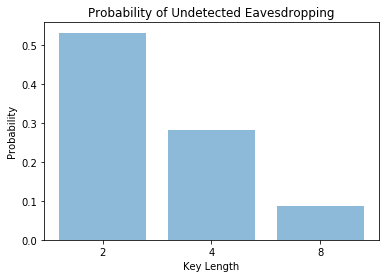

In [229]:
plot_eve_undetected(probs)